In [ ]:
# write mouse info and kind of stimulation

mouse_id = "mouse-id"
stim = 1
# visual oddball - 0
# visual angle   - 1
# elect hind paw - 2

In [ ]:
# direct save folder

hemo_folder = "hemo-corrected_dir"
img_save = f"{hemo_folder}/img/{mouse_id}"
roi_save = f"{hemo_folder}/roi/{mouse_id}"
svd_save = f"{hemo_folder}/svd_components/{mouse_id}"

stim_start = 20
stim_end = 30

start_reconst = 5  # start analysis
end_reconst = 39   # end analysis

# add experiment IDs
experiments_list = [
                    "ex1",
#                    "ex2",
#                    "ex3",
                    ]

In [ ]:
# set save folder

localdisk = "base_path"
dat_path = "img_path"
ccf_path = "ccf_path"
template_path =  f"{dat_path}/template_dir"
print(dat_path)
print(localdisk)
fs = 20 # per channel
time = 40

In [ ]:
# import libraries

import os
from os.path import join as pjoin
from tifffile import *
from wfield import *
from glob import glob

In [ ]:
# make saving folders

for ex_list in range(len(experiments_list)):
    os.mkdir(f"{img_save}/{experiments_list[ex_list]}")
    os.mkdir(f"{roi_save}/{experiments_list[ex_list]}")
    os.mkdir(f"{svd_save}/{experiments_list[ex_list]}")

In [ ]:
# load images

import numpy as np
import tqdm

ex_all = 10  # number of experiments

raw_tif = []
for ex in tqdm.tqdm(range(ex_all)):
    subfolder = pjoin(dat_path, f"ex{ex}")
    file_path = os.path.join(subfolder, f"ex{ex}.npy")
    raw_tifs = np.load(file_path)
    raw_tifs = raw_tifs[fs*start_reconst*2-2:fs*end_reconst*2+2]
    raw_tif.append(raw_tifs)

raw_tif = np.array(raw_tif)
raw_tif = np.concatenate(raw_tif, axis=0)

print(raw_tif.shape)

100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


(40920, 256, 270)


In [ ]:
# devide into 2 channels

import numpy as np

nframes, H, W = raw_tif.shape
dat = raw_tif.reshape((int(nframes/2), 2, H, W))

print(f"dat.shape:{dat.shape}")

dat.shape:(20460, 2, 256, 270)


In [ ]:
# delete raw images

del raw_tif

In [ ]:
# import libraries

from wfield import *
import os
from os.path import join as pjoin
import matplotlib.pyplot as plt
from tifffile import *
from scripts.decomposition_tif_legacy_6 import *

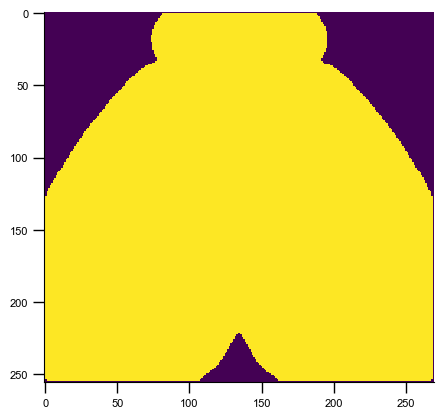

In [ ]:
# load brain mask

brain_mask = np.load("mask_path")

plt.imshow(brain_mask)

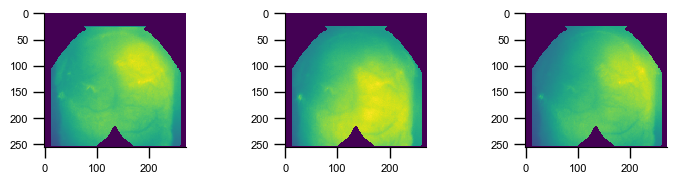

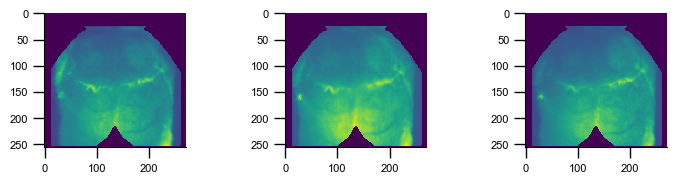

In [ ]:
# check mask and images each day

import matplotlib.pyplot as plt


frames = fs*(end_reconst-start_reconst)+2
ex_num = 10  # number of sessions per day

plt.figure(figsize=(15, 8))  # width 15 inch, height 8 inch
for ex in range(len(experiments_list)):  # Start from 1 and end at 15 (inclusive)
  plt.subplot(4, 5, ex+1)
  plt.imshow(dat[ex*ex_num*frames, 0])
  # ... rest of your code
plt.show()

plt.figure(figsize=(15, 8))  # width 15 inch, height 8 inch
for ex in range(len(experiments_list)):  # Start from 1 and end at 15 (inclusive)
  plt.subplot(4, 5, ex+1)
  plt.imshow(dat[ex*ex_num*frames, 1])
  # ... rest of your code
plt.show()

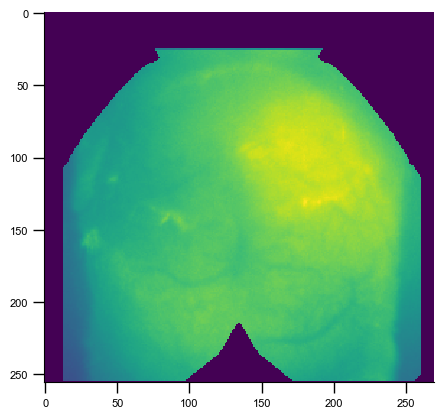

In [ ]:
# check 1st frame

plt.imshow(dat[0, 0])

In [ ]:
# make function for new mask of shared area

import numpy as np
from matplotlib.path import Path

def mask_outside_polygon(mask: np.ndarray,
                         polygon_rc: list[tuple[int,int]]
                        ) -> np.ndarray:
    H, W = mask.shape

    # (row, col) -> (x, y)
    polygon_xy = [(col, row) for (row, col) in polygon_rc]

    xs, ys = np.meshgrid(np.arange(W), np.arange(H))
    points = np.vstack((xs.ravel(), ys.ravel())).T  # (H*W, 2)

    path = Path(polygon_xy)
    inside = path.contains_points(points).reshape(H, W)

    result = mask.copy()
    result[~inside] = False
    return result


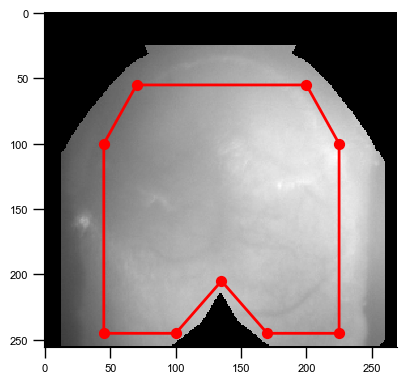

In [ ]:
# set location for new mask

import numpy as np
import matplotlib.pyplot as plt

# (x, y)
mask = dat[dat.shape[0]-1, 0]
polygon_rc = [
    (55,  70),
    (55, 200),
    (100,225),
    (245,225),
    (245,170),
    (205,135),
    (245,100),
    (245, 45),
    (100, 45),
]

plt.figure(figsize=(6, 4))
plt.imshow(mask, cmap='gray', origin='upper')

ys = [row for row, col in polygon_rc]
xs = [col for row, col in polygon_rc]

xs_closed = xs + [xs[0]]
ys_closed = ys + [ys[0]]
plt.plot(xs_closed, ys_closed, '-r', lw=2, label='Polygon')  # red line shows mask

plt.scatter(xs, ys, c='r', s=50)


plt.tight_layout()
plt.show()


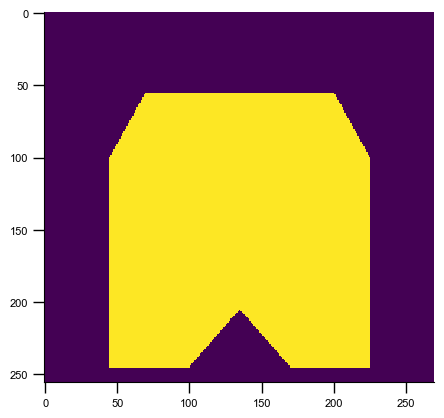

In [ ]:
# make new mask

mask_cortex = mask_outside_polygon(brain_mask, polygon_rc)

plt.imshow(mask_cortex)

In [ ]:
# save new mask

np.save(os.path.join(dat_path, "mask_cortex.npy"), mask_cortex)

In [ ]:
# make function for SVD

import tqdm

def batch_approximate_svd(datasets, onsets=None,
                          k=200, mask=None,
                          nframes_per_bin=40, nbinned_frames=200,
                          nframes_per_chunk=800, divide_by_average=True,
                          frames=800, start_ave=5, end_ave=15):

    datasets = [datasets[i : i+frames] for i in range(0, datasets.shape[0], frames)]
    #datasets =  np.split(datasets, int(datasets.shape[0]/frames), axis=0)

    U_list, SVT_list, s_list = [], [], []

    for dat in tqdm.tqdm(datasets):
        frames_average = np.mean(dat[fs*start_ave:fs*end_ave], axis=0)
        U, SVT, s = approximate_svd_tif(
            dat,
            frames_average=frames_average,
            onsets=onsets,
            k=k,
            mask=mask,
            nframes_per_bin=nframes_per_bin,
            nbinned_frames=nbinned_frames,
            nframes_per_chunk=nframes_per_chunk,
            divide_by_average=divide_by_average
        )
        U_list.append(U)
        SVT_list.append(SVT)
        s_list.append(s)


    U_list = np.array(U_list)
    SVT_list = np.array(SVT_list)
    s_list = np.array(s_list)

    return U_list, SVT_list, s_list

In [ ]:
# do SVD

ncomponents_svd = 200

U, SVT, s = batch_approximate_svd(
    datasets=dat,
    onsets=None,
    nframes_per_chunk=680,
    k=200,
    mask=mask_cortex,
    frames=fs*(end_reconst-start_reconst)+2,
    start_ave=5,
    end_ave=11
)

print(U.shape)
print(SVT.shape)
print(s.shape)

100%|██████████| 30/30 [00:31<00:00,  1.04s/it]

(30, 256, 270, 34)
(30, 34, 1364)
(30, 34)


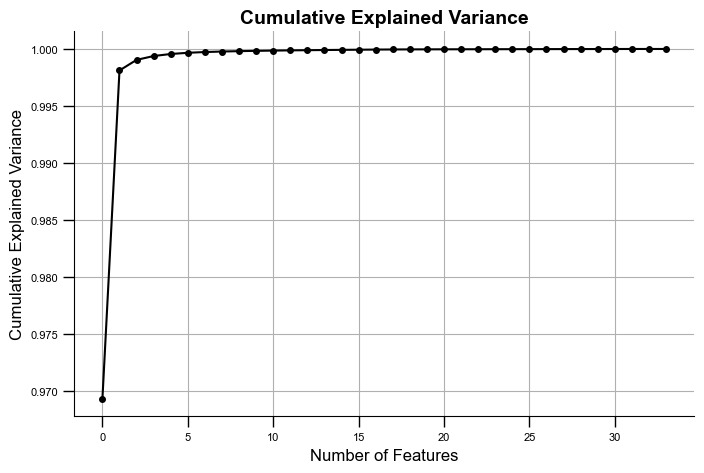

In [ ]:
# check explained variance

import numpy as np
import matplotlib.pyplot as plt

mean_s = np.mean(s, axis=0)
# singular value
explained_variance = (mean_s ** 2) / np.sum(mean_s ** 2)

cumulative_explained_variance = np.cumsum(explained_variance)

# visualze
num_features = SVT.shape[1]
plt.figure(figsize=(8, 5))
plt.plot(range(0, num_features), cumulative_explained_variance[:num_features], marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [ ]:
# do hemodynamic correction

import tqdm

SVT_470 = []
SVT_405 = []
SVTcorr = []
for ex in tqdm.tqdm(range(SVT.shape[0])):
    temp_SVT_470 = SVT[ex, :,0::2]
    t = np.arange(SVT[ex].shape[1]) # interpolate the violet
    from scipy.interpolate import interp1d
    temp_SVT_405 = interp1d(t[1::2],SVT[ex, :,1::2],axis=1,
                        fill_value='extrapolate')(t[0::2])
    temp_SVTcorr, rcoeffs, T = hemodynamic_correction(U[ex],
                                                temp_SVT_470,
                                                temp_SVT_405,
                                                fs=fs,
                                                freq_lowpass=10)
    SVT_470.append(temp_SVT_470)
    SVT_405.append(temp_SVT_405)
    SVTcorr.append(temp_SVTcorr)

SVT_470 = np.array(SVT_470)
SVT_405 = np.array(SVT_405)
SVTcorr = np.array(SVTcorr)

print(SVT_470.shape)
print(SVT_405.shape)
print(SVTcorr.shape)

  0%|          | 0/30 [00:00<?, ?it/s]

Skipping lowpass on the violet channel.


  3%|▎         | 1/30 [00:03<01:37,  3.37s/it]

Skipping lowpass on the violet channel.


  7%|▋         | 2/30 [00:06<01:30,  3.23s/it]

Skipping lowpass on the violet channel.


 10%|█         | 3/30 [00:09<01:26,  3.21s/it]

Skipping lowpass on the violet channel.


 13%|█▎        | 4/30 [00:12<01:20,  3.11s/it]

Skipping lowpass on the violet channel.


 17%|█▋        | 5/30 [00:15<01:17,  3.08s/it]

Skipping lowpass on the violet channel.


 20%|██        | 6/30 [00:18<01:13,  3.05s/it]

Skipping lowpass on the violet channel.


 23%|██▎       | 7/30 [00:21<01:10,  3.06s/it]

Skipping lowpass on the violet channel.


 27%|██▋       | 8/30 [00:25<01:09,  3.14s/it]

Skipping lowpass on the violet channel.


 30%|███       | 9/30 [00:28<01:04,  3.09s/it]

Skipping lowpass on the violet channel.


 33%|███▎      | 10/30 [00:30<01:00,  3.04s/it]

Skipping lowpass on the violet channel.


 37%|███▋      | 11/30 [00:33<00:57,  3.01s/it]

Skipping lowpass on the violet channel.


 40%|████      | 12/30 [00:36<00:54,  3.01s/it]

Skipping lowpass on the violet channel.


 43%|████▎     | 13/30 [00:39<00:51,  3.00s/it]

Skipping lowpass on the violet channel.


 47%|████▋     | 14/30 [00:42<00:47,  3.00s/it]

Skipping lowpass on the violet channel.


 50%|█████     | 15/30 [00:45<00:45,  3.01s/it]

Skipping lowpass on the violet channel.


 53%|█████▎    | 16/30 [00:48<00:42,  3.01s/it]

Skipping lowpass on the violet channel.


 57%|█████▋    | 17/30 [00:51<00:39,  3.01s/it]

Skipping lowpass on the violet channel.


 60%|██████    | 18/30 [00:55<00:36,  3.02s/it]

Skipping lowpass on the violet channel.


 63%|██████▎   | 19/30 [00:58<00:33,  3.02s/it]

Skipping lowpass on the violet channel.


 67%|██████▋   | 20/30 [01:00<00:30,  3.00s/it]

Skipping lowpass on the violet channel.


 70%|███████   | 21/30 [01:03<00:26,  2.99s/it]

Skipping lowpass on the violet channel.


 73%|███████▎  | 22/30 [01:06<00:24,  3.01s/it]

Skipping lowpass on the violet channel.


 77%|███████▋  | 23/30 [01:09<00:21,  3.00s/it]

Skipping lowpass on the violet channel.


 80%|████████  | 24/30 [01:13<00:18,  3.01s/it]

Skipping lowpass on the violet channel.


 83%|████████▎ | 25/30 [01:16<00:15,  3.02s/it]

Skipping lowpass on the violet channel.


 87%|████████▋ | 26/30 [01:19<00:12,  3.00s/it]

Skipping lowpass on the violet channel.


 90%|█████████ | 27/30 [01:22<00:09,  3.05s/it]

Skipping lowpass on the violet channel.


 93%|█████████▎| 28/30 [01:25<00:06,  3.09s/it]

Skipping lowpass on the violet channel.


 97%|█████████▋| 29/30 [01:28<00:03,  3.05s/it]

Skipping lowpass on the violet channel.


100%|██████████| 30/30 [01:31<00:00,  3.05s/it]

(30, 34, 682)
(30, 34, 682)
(30, 34, 682)


In [ ]:
# delete 1st and final frame to escape error

SVT_470 = SVT_470[:, :, 1:-1]
SVT_405 = SVT_405[:, :, 1:-1]
SVTcorr = SVTcorr[:, :, 1:-1]

print(U.shape)
print(SVT_470.shape)
print(SVT_405.shape)
print(SVTcorr.shape)

(30, 256, 270, 34)
(30, 34, 680)
(30, 34, 680)
(30, 34, 680)


In [ ]:
# save SVD components

np.save(os.path.join(dat_path, "U.npy"), U)
np.save(os.path.join(dat_path, "SVTcorr.npy"), SVTcorr)
np.save(os.path.join(dat_path, "SVT_470.npy"), SVT_470)
np.save(os.path.join(dat_path, "SVT_405.npy"), SVT_405)
np.save(os.path.join(dat_path, "singular_value.npy"), s)

In [ ]:
# make function for reconstruct images from SVD components

def my_reconstruct(u,svt,dims = None):
    '''
    Reconstruct a decomposed signal (e.g. decomposed with SVD for example).

    Can also reconstruct sparse arrays, use dims when reconstructing sparse.

    Usage:
        res = reconstruct(u,svt,dims = None)

    Joao Couto - wfield, 2020
    '''
    if issparse(u):
        if dims is None:
            raise ValueError('Supply dims = [H,W] when using sparse arrays')
    else:
        if dims is None:
            dims = u.shape[:2]

    return np.matmul(u, svt).reshape((*dims,-1)).transpose(-1,0,1).squeeze()

In [ ]:
# set thr number of components you use

ncomps = SVTcorr.shape[1]
frame = fs*(end_reconst-start_reconst)

In [ ]:
# make reconstructed images

import tqdm

mov_all = []
for ex in tqdm.tqdm(range(SVTcorr.shape[0])):
    temp_mov = my_reconstruct(U[ex, :, :, :ncomps], SVTcorr[ex, :ncomps])
    mov_all.append(temp_mov)

#mov_all = np.array(mov_all)
print(len(mov_all))

100%|██████████| 30/30 [00:02<00:00, 14.02it/s]

30


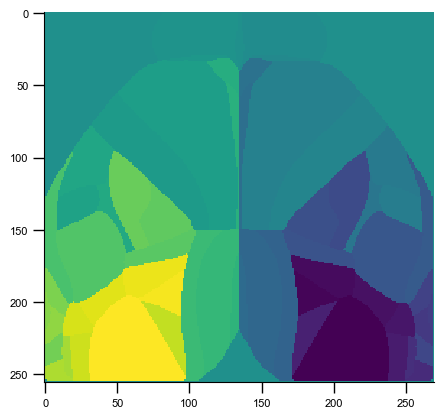

In [ ]:
# load atlas brain map

atlas = np.load("atlas_path").astype(int)
plt.imshow(atlas)

In [ ]:
# make traces for each brain region

# ROIs applied to atlas
unique_values = np.unique(atlas)
roi_means = []
roi_positions = []

for val in tqdm.tqdm(unique_values):
    mask = (atlas == val)
    if np.sum(mask) > 0:
        y_indices, x_indices = np.where(mask)
        center_x, center_y = int(np.mean(x_indices)), int(np.mean(y_indices))
        roi_positions.append((center_x, center_y, val))
        temp_roi_means = []
        for ex in range(len(mov_all)):
            temp_mov = mov_all[ex]
            mean_values = np.mean(temp_mov[:, mask], axis=1)  # average time course in ROIs
            temp_roi_means.append(mean_values)
        roi_means.append(temp_roi_means)



# (ROIs, frames)
roi_means_array = np.array(roi_means)

100%|██████████| 61/61 [00:03<00:00, 19.88it/s]


In [ ]:
# reshape traces array

roi_means_array = roi_means_array.reshape(roi_means_array.shape[0], roi_means_array.shape[1]*roi_means_array.shape[2])
print(roi_means_array.shape)

(61, 20400)


In [ ]:
# direct regions you use

frames = fs*(end_reconst-start_reconst)

# left ROI IDs
indices_to_left = [-33,-32,-31,-27,-18,-17,-16,-12,-11,-10,-9,-4,-3,
                   3,4,9,10,11,12,16,17,18,27,31,32,33]


index_left = [index for index, value in enumerate(unique_values.tolist()) if value in indices_to_left]

print(index_left)
print(len(indices_to_left))

[0, 1, 2, 6, 13, 14, 15, 18, 19, 20, 21, 26, 27, 33, 34, 39, 40, 41, 42, 45, 46, 47, 54, 58, 59, 60]
26


In [ ]:
# record ROI number in atlas

roi_numbers = []
roi_traces = []
for j, i in enumerate(index_left):
    roi_numbers.append(unique_values[i])
    roi_traces.append(roi_means_array[i])

roi_numbers = np.array(roi_numbers)
roi_traces = np.array(roi_traces)

print(roi_numbers)
print(roi_numbers.shape)
print(roi_traces.shape)

[-33 -32 -31 -27 -18 -17 -16 -12 -11 -10  -9  -4  -3   3   4   9  10  11
  12  16  17  18  27  31  32  33]
(26,)
(26, 20400)


In [ ]:
# record region name

# ROIs' name
roi_names = np.array([' VISp_R  ', ' VISam_R ', ' VISa_R  ', ' VISpm_R ',
                 'SSp-ul_R ', 'SSp-ll_R ', 'SSp-tr_R ',
                 'RSPagl_R ', ' RSPd_R  ', ' RSPv_R  ',
                 ' ACAd_R  ',
                 '  MOs_R  ', '  MOp_R  ',
                 '  MOp_L  ', '  MOs_L  ',
                 ' ACAd_L  ',
                 ' RSPv_L  ', ' RSPd_L  ', 'RSPagl_L ',
                 'SSp-tr_L ', 'SSp-ll_L ', 'SSp-ul_L ',
                 ' VISpm_L ', ' VISa_L  ', ' VISam_L ', ' VISp_L  '
                 ])

print(roi_names.shape)

(26,)


In [ ]:
# make function to visualize activities of a ROI you want to see in your whole experient

import numpy as np
import matplotlib.pyplot as plt

frames = fs*(end_reconst-start_reconst)

def roi_calc(img_array):
    time_steps, height, width = img_array.shape
    roi = np.zeros((height, width), dtype=bool)
    roi[200:230, 180:210] = 1  # (y, x)
    mean_values = np.array([np.mean(frame[roi]) for frame in img_array])

    return mean_values

In [ ]:
# set time frames

# start time
start_value = 0.0

# increase per frames
increment = 0.05

# frames
count = 800

t = [start_value + i * increment for i in range(count)]

In [ ]:
# show hemodynamic-corrected ΔF/F of your ROI in your whole experiment

plt.figure(figsize=(20, 20))  # width 20 inch, height 20 inch

for ex in range(int(len(mov_all))):
    mean_values = roi_calc(mov_all[ex])
    plt.subplot(10, 5, ex+1)
    plt.plot(t[:frames], mean_values, color='green')
    if stim == 0:
        for set in range(11):
            plt.axvspan(set+0.5, set+1, color='black', alpha=0.3)
        for set in range(11, 34):
            plt.axvspan(set+0.5, set+1, color='blue', alpha=0.3)
        for dev in range(3):
            plt.axvspan(dev*8+16.5, dev*8+17, color='red', alpha=0.3)
    if stim == 1:
        plt.axvspan(15, 25, color='red', alpha=0.3)
    if stim == 2:
        plt.axvspan(15, 15.5, color='red', alpha=0.3)
    plt.ylim(-0.01, 0.01)

plt.show()

In [ ]:
# save images and SVD components to new folders

import tqdm

ex_num = 10                      # sessions per day
frames = SVTcorr.shape[2]        # frames per experiments

for ex_list in tqdm.tqdm(range(len(experiments_list))):
    for ex in range(ex_num):
        np.save(f"{img_save}/{experiments_list[ex_list]}/{experiments_list[ex_list]}_ex0{ex}.npy", mov_all[ex_list*ex_num+ex])
        np.save(f"{roi_save}/{experiments_list[ex_list]}/{experiments_list[ex_list]}_ex0{ex}.npy", roi_traces[:, (ex_list*ex_num+ex)*frames:(ex_list*ex_num+ex+1)*frames])
        np.save(f"{svd_save}/{experiments_list[ex_list]}/{experiments_list[ex_list]}_ex0{ex}_U.npy", U[ex_list*ex_num+ex])
        np.save(f"{svd_save}/{experiments_list[ex_list]}/{experiments_list[ex_list]}_ex0{ex}_SVTcorr.npy", SVTcorr[ex_list*ex_num+ex])
        np.save(f"{svd_save}/{experiments_list[ex_list]}/{experiments_list[ex_list]}_ex0{ex}_SVT_470.npy", SVT_470[ex_list*ex_num+ex])
        np.save(f"{svd_save}/{experiments_list[ex_list]}/{experiments_list[ex_list]}_ex0{ex}_SVT_405.npy", SVT_405[ex_list*ex_num+ex])
        np.save(f"{svd_save}/{experiments_list[ex_list]}/{experiments_list[ex_list]}_ex0{ex}_singular_value.npy", s[ex_list*ex_num+ex])

100%|██████████| 3/3 [02:38<00:00, 52.82s/it]
